In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from shutil import copyfile, rmtree
from timeit import default_timer as timer

In [2]:
# Вспомогательная функция для доступа к файлам относительно корня директория с данными.
INPUT_ROOT = "../input/gtsrb-german-traffic-sign"
def from_input(path):
    return os.path.join(INPUT_ROOT, path)

In [3]:
# Загружаем таблицу с данными о данных.
train_info = pd.read_csv(from_input("Train.csv"))
train_info.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [4]:
# Посмотрим как выглядят наши данные.
train_info.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000
mean,50.835880,50.328930,5.999515,5.962381,45.197302,44.728379,15.788390
std,24.306933,23.115423,1.475493,1.385440,23.060157,21.971145,12.013238
min,25.000000,25.000000,0.000000,5.000000,20.000000,20.000000,0.000000
25%,35.000000,35.000000,5.000000,5.000000,29.000000,30.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,58.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,243.000000,225.000000,20.000000,20.000000,223.000000,205.000000,42.000000


In [5]:
# сколько примеров в каждом из классов
train_info.groupby('ClassId')['ClassId'].count()

ClassId
0      210
1     2220
2     2250
3     1410
4     1980
5     1860
6      420
7     1440
8     1410
9     1470
10    2010
11    1320
12    2100
13    2160
14     780
15     630
16     420
17    1110
18    1200
19     210
20     360
21     330
22     390
23     510
24     270
25    1500
26     600
27     240
28     540
29     270
30     450
31     780
32     240
33     689
34     420
35    1200
36     390
37     210
38    2070
39     300
40     360
41     240
42     240
Name: ClassId, dtype: int64

In [6]:
test_info =  pd.read_csv(from_input("Test.csv"))
test_info.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [7]:
test_info.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000
mean,50.507759,50.364450,5.998021,5.982423,44.864450,44.758116,15.551069
std,25.088483,23.698908,1.543954,1.427424,23.776102,22.494697,11.947123
min,25.000000,25.000000,1.000000,5.000000,20.000000,20.000000,0.000000
25%,34.000000,35.000000,5.000000,5.000000,29.000000,29.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,57.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,266.000000,232.000000,23.000000,19.000000,244.000000,212.000000,42.000000


In [8]:
# сколько примеров в каждом из классов
test_info.groupby('ClassId')['ClassId'].count()

ClassId
0      60
1     720
2     750
3     450
4     660
5     630
6     150
7     450
8     450
9     480
10    660
11    420
12    690
13    720
14    270
15    210
16    150
17    360
18    390
19     60
20     90
21     90
22    120
23    150
24     90
25    480
26    180
27     60
28    150
29     90
30    150
31    270
32     60
33    210
34    120
35    390
36    120
37     60
38    690
39     90
40     90
41     60
42     90
Name: ClassId, dtype: int64

In [9]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Показываем изображения в сетке 6х8.
nrows = 8
ncols = 6

pic_offset = 0 # Чтобы итерировать по изображениям каждый раз когда запустим код ниже.

In [10]:
def show_images(offset):
    fig = plt.gcf()
    fig.set_size_inches(ncols*3, nrows*3)

    for i in range(43):
        # subplot индексы начинаются с 1
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('Off')
        subdir = os.path.join(from_input('train'), str(i))
        files = os.listdir(subdir)
        img_path = os.path.join(subdir, files[offset % len(files)])
        img = mpimg.imread(img_path)
        #print(img.shape)
        plt.imshow(img)

    plt.show()

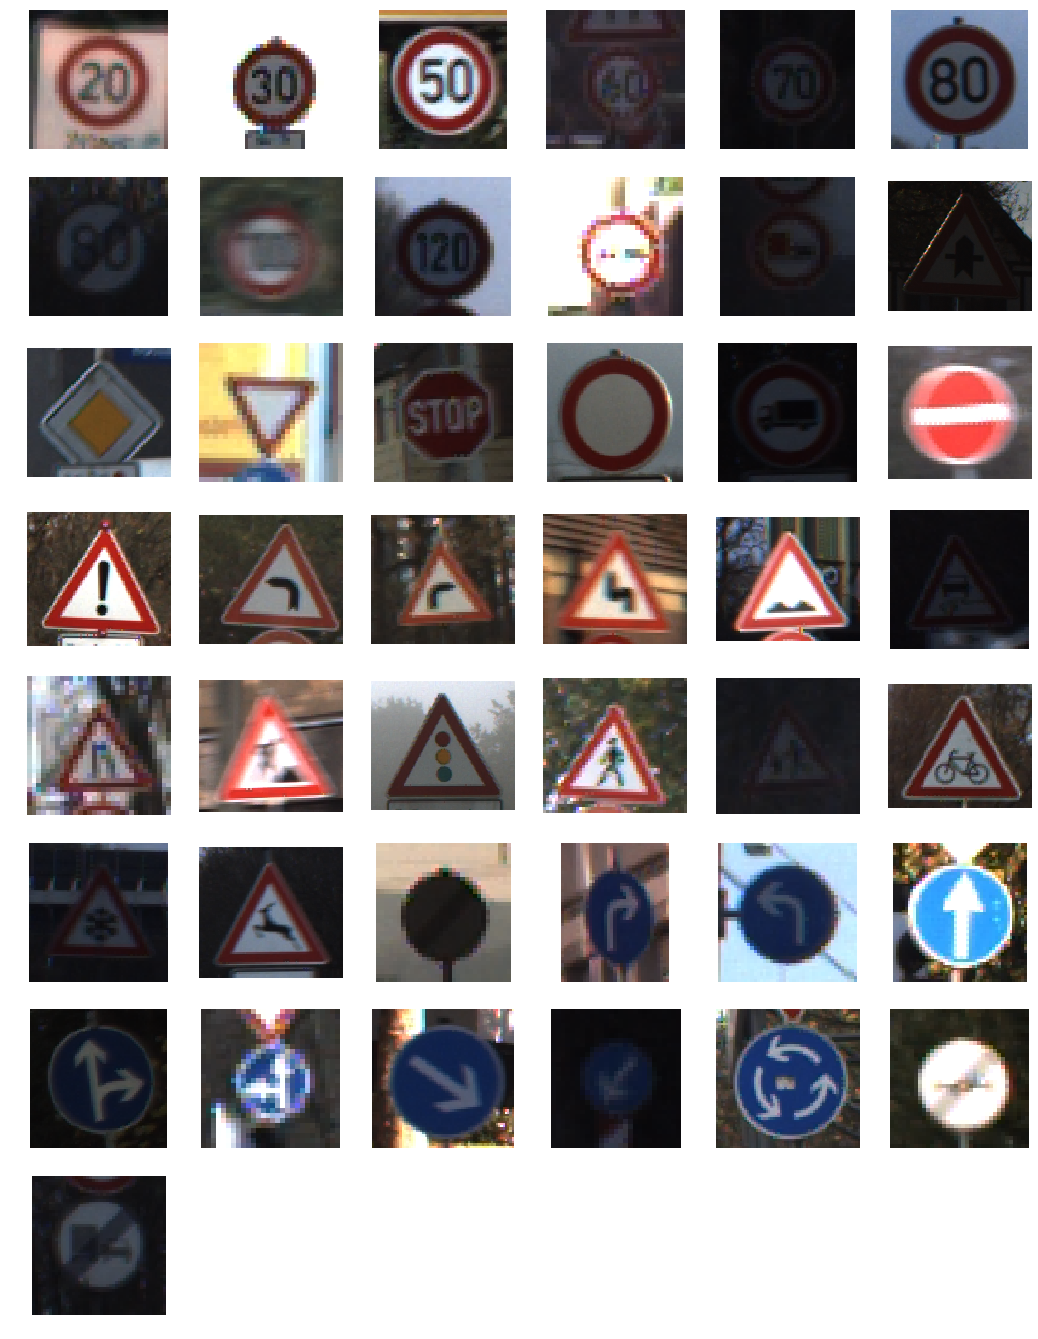

In [11]:
show_images(pic_offset)
pic_offset += 1

In [12]:
VALIDATION_RATIO = 0.2 # часть изображений в валидационной выборке
TARGET_SIZE = (40, 40) # изображения будут изменены до этого размера

In [13]:
paths = train_info['Path'].values
y_train = train_info['ClassId'].values

indices = np.arange(y_train.shape[0])
randgen = random.Random(62)
randgen.shuffle(indices)

paths = paths[indices]
y_train = y_train[indices]

data=[]

for i, f in enumerate(paths):
    print('\rLoading data {0:.1f}%...'.format((i / len(paths)) * 100), end = '\r')
    image = Image.open(os.path.join(from_input('train'), f.replace('Train/', '')))
    resized_image = image.resize(TARGET_SIZE)
    data.append(np.array(resized_image))

X_train = np.array(data).astype('float32') / 255.0

split_size = 1 - VALIDATION_RATIO
train_size = int(y_train.shape[0] * split_size)

y_train = to_categorical(y_train, 43)
y_val = y_train[train_size:]
y_train = y_train[:train_size]

X_val = X_train[train_size:]
X_train = X_train[:train_size]

print('Data loaded.              ')

Data loaded.              


In [14]:
class StopOnAccReachedCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs['acc'] >= 0.999 and logs['val_acc'] >= 0.999:
            self.model.stop_training = True
            print("\nReached accuracy {} at epoch {}, stopping...".format(logs['acc'], epoch))

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(100, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(43, activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 38, 38, 100)       2800      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 19, 100)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36100)             0         
_________________________________________________________________
dense (Dense)                (None, 43)                1552343   
Total params: 1,555,143
Trainable params: 1,555,143
Non-trainable params: 0
_________________________________________________________________


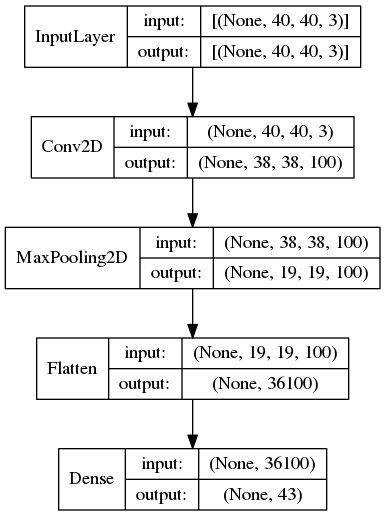

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [17]:
BATCH_SIZE = 300

In [18]:
train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(X_train,
                                    y_train,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    seed=17)

validation_datagen = ImageDataGenerator()
validation_generator = validation_datagen.flow(X_val,
                                    y_val,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    seed=17)

In [19]:
start_time = timer()
history = model.fit_generator(train_generator,
                    epochs=20,
                    verbose=1,
                    callbacks=[
                      tf.keras.callbacks.EarlyStopping(monitor='acc', min_delta=0.0001, patience=2),
                      StopOnAccReachedCallback()
                    ],
                    steps_per_epoch = round(X_train.shape[0] / BATCH_SIZE),
                    validation_data = validation_generator)
end_time = timer()
print('Trained in {0:.2f} minutes'.format((end_time - start_time) / 60))

Epoch 1/20
105/105 [==============================] - 4s 40ms/step - loss: 1.6404 - acc: 0.5965 - val_loss: 0.7127 - val_acc: 0.8151
Epoch 2/20
105/105 [==============================] - 2s 20ms/step - loss: 0.4814 - acc: 0.8915 - val_loss: 0.3864 - val_acc: 0.9078
Epoch 3/20
105/105 [==============================] - 2s 20ms/step - loss: 0.2664 - acc: 0.9442 - val_loss: 0.2602 - val_acc: 0.9422
Epoch 4/20
105/105 [==============================] - 2s 21ms/step - loss: 0.1768 - acc: 0.9634 - val_loss: 0.1966 - val_acc: 0.9529
Epoch 5/20
105/105 [==============================] - 2s 21ms/step - loss: 0.1285 - acc: 0.9742 - val_loss: 0.1646 - val_acc: 0.9624
Epoch 6/20
105/105 [==============================] - 2s 20ms/step - loss: 0.0972 - acc: 0.9815 - val_loss: 0.1515 - val_acc: 0.9629
Epoch 7/20
105/105 [==============================] - 2s 20ms/step - loss: 0.0762 - acc: 0.9855 - val_loss: 0.1304 - val_acc: 0.9684
Epoch 8/20
105/105 [==============================] - 2s 20ms/step - 

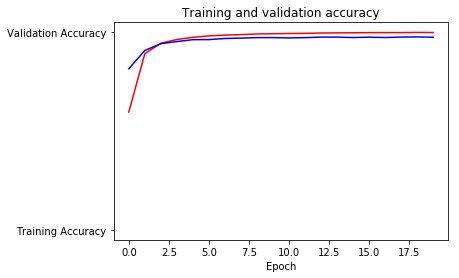

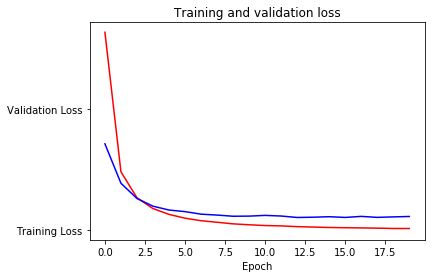

In [20]:
def plot(history):
    %matplotlib inline

    import matplotlib.image  as mpimg
    import matplotlib.pyplot as plt

    acc=history.history['acc']
    val_acc=history.history['val_acc']
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    epochs=range(len(acc))

    plt.plot(epochs, acc, 'r', "Training Accuracy")
    plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.figure()

    plt.plot(epochs, loss, 'r', "Training Loss")
    plt.plot(epochs, val_loss, 'b', "Validation Loss")
    plt.xlabel('Epoch')
    plt.title('Training and validation loss')

plot(history)

In [21]:
# Тестируем
paths = test_info['Path'].values
y_test = test_info['ClassId'].values
y_test = to_categorical(y_test, 43)

data=[]

for f in paths:
    image = Image.open(os.path.join(from_input('test'), f.replace('Test/', '')))
    resized_image = image.resize(TARGET_SIZE)
    data.append(np.array(resized_image))

X_test = np.array(data).astype('float32') / 255.0 

In [22]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(X_test,
                                    y_test,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    seed=17)

In [23]:
result = model.evaluate_generator(test_generator)
print(model.metrics_names)
print(result)

['loss', 'acc']
[0.7132599000320878, 0.8873317]


In [24]:
def show_layer_activations(model):
    for l in model.layers:
        if hasattr(l, 'activation'):
            print(l.name, l.activation.__name__)
        else:
            print(l.name, '<none>')


def show_model_activations_and_summary(model):
    show_layer_activations(model)
    model.summary()


def show_model_activations_and_summaries(models):
    for i, model in enumerate(models):
        print('Model {}:'.format(i))
        show_model_activations_and_summary(model)
        print('\n\n')

In [25]:
def try_different_models(models):
    val_accs = []
    for i, model in enumerate(models):
        print('Training network {}...'.format(i))
        model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
        start_time = timer()
        history = model.fit_generator(train_generator,
                            epochs=20,
                            verbose=0,
                            callbacks=[
                              tf.keras.callbacks.EarlyStopping(monitor='acc', min_delta=0.0001, patience=2),
                              StopOnAccReachedCallback()
                            ],
                            steps_per_epoch= round(X_train.shape[0] / BATCH_SIZE),
                            validation_data = validation_generator)
        end_time = timer()
        acc=history.history['acc'][-1]
        val_acc=history.history['val_acc'][-1]
        val_accs.append(val_acc)
        print('Network {0:d}, results at the end of training: acc={1:.02f}%, val_acc={2:.02f}%'
              .format(i, acc*100, val_acc*100))
        print('Trained in {0:.2f} minutes'.format((end_time - start_time) / 60))
        print('\n')
    return val_accs

In [26]:
models = [
    tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(43, activation='softmax')
    ]),
    tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(43, activation='softmax')
    ]),
    tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(43, activation='softmax')
    ]),
    tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(43, activation='softmax')
    ]),
    tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3, 3), activation='tanh', input_shape=TARGET_SIZE + (3,)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='tanh'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(256, (3, 3), activation='tanh'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(43, activation='softmax')
    ]),
    tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='tanh', input_shape=TARGET_SIZE + (3,)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='tanh'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='tanh'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(43, activation='softmax')
    ]),
    tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(256, (3, 3), activation='tanh'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(512, (3, 3), activation='tanh'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(43, activation='softmax')
    ]),
    tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(256, (3, 3), activation='tanh'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(512, (3, 3), activation='tanh'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(43, activation='softmax')
    ])
]

In [27]:
show_model_activations_and_summaries(models)

Model 0:
conv2d_1 relu
max_pooling2d_1 <none>
flatten_1 <none>
dense_1 softmax
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 38, 38, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 19, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 23104)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 43)                993515    
Total params: 995,307
Trainable params: 995,307
Non-trainable params: 0
_________________________________________________________________



Model 1:
conv2d_2 relu
max_pooling2d_2 <none>
conv2d_3 relu
max_pooling2d_3 <none>
flatten_2 <none>
dense_2 softmax
Model: "sequential_2"
__________________________

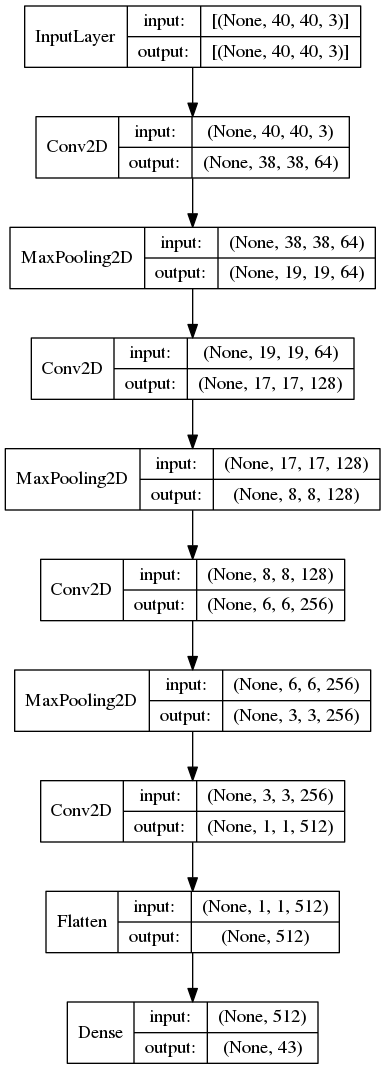

In [28]:
tf.keras.utils.plot_model(models[3], show_shapes=True, show_layer_names=False)

In [29]:
val_accs = try_different_models(models)

Training network 0...
Network 0, results at the end of training: acc=99.47%, val_acc=97.55%
Trained in 0.54 minutes


Training network 1...
Network 1, results at the end of training: acc=99.58%, val_acc=98.38%
Trained in 0.54 minutes


Training network 2...
Network 2, results at the end of training: acc=99.48%, val_acc=98.56%
Trained in 0.58 minutes


Training network 3...
Network 3, results at the end of training: acc=99.61%, val_acc=98.74%
Trained in 0.56 minutes


Training network 4...
Network 4, results at the end of training: acc=100.00%, val_acc=99.45%
Trained in 0.50 minutes


Training network 5...
Network 5, results at the end of training: acc=99.99%, val_acc=99.40%
Trained in 0.52 minutes


Training network 6...
Network 6, results at the end of training: acc=100.00%, val_acc=99.39%
Trained in 0.45 minutes


Training network 7...
Network 7, results at the end of training: acc=100.00%, val_acc=99.49%
Trained in 0.50 minutes




In [30]:
import operator
max_index, max_value = max(enumerate(val_accs), key=operator.itemgetter(1))
print('Best validation accuracy ({0:.4f}) achived with model #{1:d}'
      .format(max_value, max_index))
best_model = models[max_index]
print('Layer activations and summary:')
show_model_activations_and_summary(best_model)

Best validation accuracy (0.9949) achived with model #7
Layer activations and summary:
conv2d_21 relu
max_pooling2d_19 <none>
conv2d_22 relu
max_pooling2d_20 <none>
conv2d_23 tanh
max_pooling2d_21 <none>
conv2d_24 tanh
flatten_8 <none>
dense_8 softmax
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 38, 38, 64)        1792      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 17, 17, 128)       73856     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 6, 6, 256)         295168    


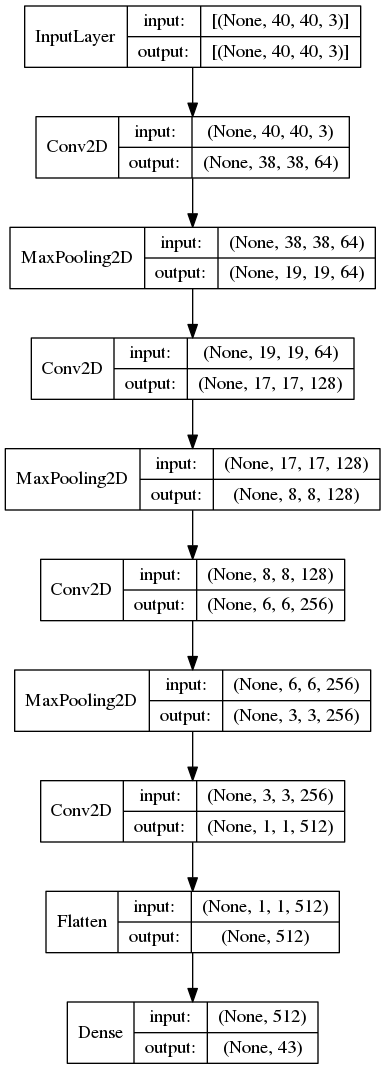

In [31]:
tf.keras.utils.plot_model(best_model, show_shapes=True, show_layer_names=False)

In [32]:
# Посмотрим результаты на тестовой выборке.
result = best_model.evaluate_generator(test_generator)
print(best_model.metrics_names)
print(result)

['loss', 'acc']
[0.20539826570555222, 0.9499604]
